In [1]:
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

meanest:       [-0.51482785 -5.35404619  3.44620449 -0.77677063  0.23580056]
meanerror:     []
est:           [ 0.31711807  0.36197324  3.77801046 -0.67111342  0.04366374]
error:         [  5.95504431e-04   8.42096818e-04   1.01966525e-05   7.60973254e-05
   2.57655111e-05]
chisq:         0.000785203021821


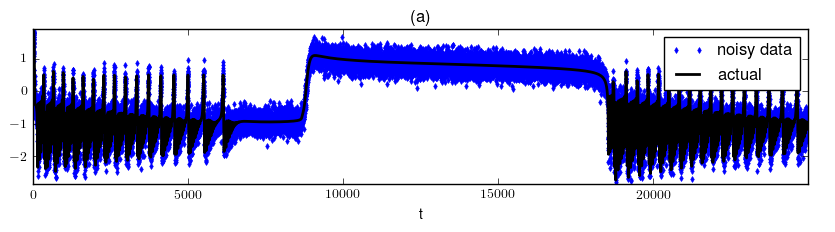

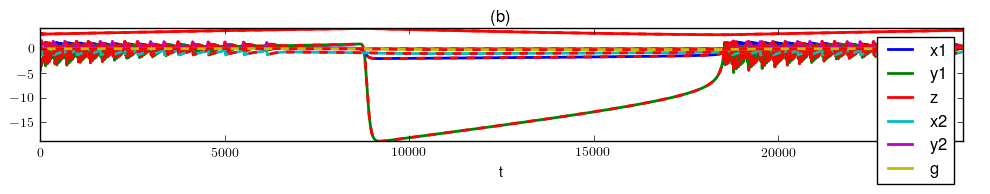

In [156]:
# voss.m function translated from schiff, ch5, p.110

dims_params = 0 # dq
dims_state_vars = 6 # dx
dims_observations = 1 # dy

model_function = epileptor_model
transition_function = epileptor_transition_function
observation_function = epileptor_observation_function
parameter_function = epileptor_parameters

total_time = 2500
dt_sample = 0.1
num_samples = int(total_time//dt_sample)
dt_integrate = dt_sample
steps_per_sample = int(dt_sample//dt_integrate)

# Set parameters for simulated data
parameters = parameter_function(num_samples)

# Preallocate arrays
dims_augmented_state = dims_params + dims_state_vars
true_state = np.zeros((dims_state_vars,num_samples)) # true trajectory
estimated_state = np.zeros((dims_augmented_state,num_samples)) # estimated trajectory
Pxx = np.zeros((dims_augmented_state,dims_augmented_state,num_samples)) # covariance in x
errors = np.zeros((dims_augmented_state, num_samples))
Ks = np.zeros((dims_augmented_state,dims_observations,num_samples))

# Initial conditions for simulation
# (initial_conditions set as global in parameter_function)
true_state[:,0] = initial_conditions

# Generate true trajectory and simulated noisy data
for n in range(num_samples-1):
    x_temp = true_state[:,n]
    true_state[:,n+1] = ruku4(model_function,x_temp,parameters[:,n],
                              dt_integrate,steps_per_sample)      
augmented_state = np.vstack((parameters,true_state)) if dims_params > 0 else true_state

# Covariances
Q = process_noise(noise)
R = observation_noise(data=observation_function(augmented_state))

noisy_data = observation_function(augmented_state) + np.matmul(la.sqrtm(R),
                                   np.random.randn(dims_observations,num_samples))

# Initialize estimated state and Pxx
estimated_state[:,0] = augmented_state[:,0]
# estimated_state[:,0] = np.zeros_like(augmented_state[:,0])
# Pxx[:,:,0] = la.block_diag(Q,R,R)
Pxx[:,:,0] = la.block_diag(R,R,R,R,R,R)


# Main loop for recursive estimation
for k in range(1,num_samples):
    try:
        estimated_state[:,k],Pxx[:,:,k],Ks[:,:,k] = voss_unscented_transform(
            estimated_state[:,k-1],Pxx[:,:,k-1],noisy_data[:,k],
            transition_function,observation_function,dims_params,dims_augmented_state,
            dims_observations, R)
    except la.LinAlgError:
        Pxx[:,:,k-1] = Pxx[:,:,k-2]
        estimated_state[:,k],Pxx[:,:,k],Ks[:,:,k] = voss_unscented_transform(
            estimated_state[:,k-1],Pxx[:,:,k-1],noisy_data[:,k],
            transition_function,observation_function,dims_params,dims_augmented_state,
            dims_observations, R)
    if dims_params > 0: Pxx[:dims_params,:dims_params,k] = Q
    errors[:,k] = np.sqrt(np.diag(Pxx[:,:,k]))
    
# Results
results = {}
results['chisq'] = np.mean(sum((augmented_state - estimated_state)**2))
results['est'] = estimated_state[:dims_params-1,-1]
results['error'] = errors[:dims_params-1,-1]
results['meanest'] = np.mean(estimated_state[:dims_params-1,:],1)
results['meanerror'] = np.mean(errors[:dims_params,:],1)
for key,value in results.items():
    print('{0:15s}{1}'.format(key+':',str(value)))

# Plotting
plt.rc('text', usetex=True)
plt.figure(figsize=(10,2))
plt.plot(noisy_data[0,:],'bd',markeredgecolor='blue', mfc='blue',ms=3,label='noisy data');
plt.plot(observation_function(augmented_state).T,'k',linewidth=2,label='actual'); 
plt.xlabel('t');
plt.legend();
plt.axis('tight')
plt.title('(a)')
plt.figure(figsize=(10,2))
var_names = ['x1', 'y1', 'z', 'x2','y2','g']
for i in range(dims_state_vars):
    plt.plot(augmented_state[dims_params+i,:],lw=2,label=var_names[i])
    plt.plot(estimated_state[dims_params+i,:],'r--',lw=2)
plt.legend()
for i in range(dims_params):
    plt.plot(estimated_state[i,:],'m',linewidth=2)
    plt.plot(estimated_state[i,:] + errors[i,:],'m')
    plt.plot(estimated_state[i,:] - errors[i,:],'m')
plt.xlabel('t')
plt.axis('tight')
plt.title('(b)')
plt.tight_layout()
plt.show()

In [144]:
k

1

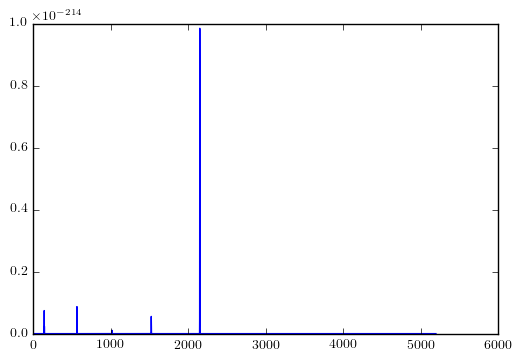

In [118]:
A = []
for i in range(k):
    A.append(np.prod(Pxx[:,:,i]))
plt.plot(A[4000:])
plt.show()

In [137]:
A = dims_state_vars*Pxx[:,:,k-1]
print(np.sum(A))
print(la.decomp_cholesky.cholesky(A))

1.34891310572
[[ 0.47415066  0.          0.          0.          0.          0.        ]
 [ 0.          0.47415066  0.          0.          0.          0.        ]
 [ 0.          0.          0.47415066  0.          0.          0.        ]
 [ 0.          0.          0.          0.47415066  0.          0.        ]
 [ 0.          0.          0.          0.          0.47415066  0.        ]
 [ 0.          0.          0.          0.          0.          0.47415066]]


In [100]:
?la.decomp_cholesky()

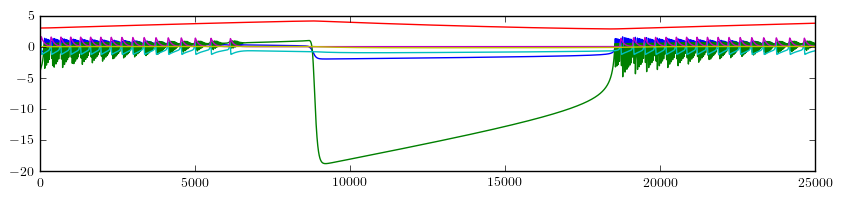

In [72]:
plt.figure(figsize=(10,2))
plt.plot(true_state.T)
plt.show()


In [717]:
Q

array([[ 0.025,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.25 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [152]:
# vossut function translated from matlab code in Schiff, ch 5, p.110

def voss_unscented_transform(xhat,Pxx,noisy_data,fct,obsfct,dims_params,dims_augmented_state,
           dims_observations,R):
    
    Pxx = symmetrize(Pxx)
    
    Xa = generate_sigma_points(xhat,Pxx)
    X = fct(dims_params,Xa)
    Y = obsfct(X).reshape(1,-1)
    
    Pxx = symmetrize(covariance(X,X))
    Pyy = covariance(Y,Y) + R
    Pxy = covariance(X,Y)
        
    K = np.matmul(Pxy,la.inv(Pyy))
    xhat = np.mean(X,1) + np.matmul(K,(noisy_data - np.mean(Y,1)))

    Pxx = symmetrize(Pxx - np.matmul(K,Pxy.T))
    
    return xhat,Pxx,K

def covariance(X,Y):
    '''Calculates biased covariance (or cross covariance) of array-like X and Y'''
    num_samples = len(X[0,:])
    X_centered = mean_center(np.array(X))
    Y_centered = mean_center(np.array(Y))
    return np.matmul(X_centered,Y_centered.T/num_samples)

def mean_center(X):
    '''Centers the mean of rows of X (array-like) around 0.'''
    return np.array([x - np.mean(x) for x in X])

def symmetrize(A):
    '''Numerical safety'''
    return (A + np.transpose(A)) / 2

def generate_sigma_points(xhat,Pxx):
    '''Why have the extra terms from the Cholesky decomp?? Why not just use sigma in each direction?'''
    dims = len(xhat)
    num_sigma_points = 2*dims
    Pxx = symmetrize(Pxx)
    xsigma = la.cholesky(dims*Pxx,lower=True)
    Xa = np.hstack((xsigma,-xsigma))
    for i in range(num_sigma_points):
        Xa[:,i]+=xhat
    return Xa

# RuKu4 integrator
def ruku4(function, state, params, dt, steps):
    for i in range(steps):
        k1 = dt*function(state,params)
        k2 = dt*function(state+k1/2,params)
        k3 = dt*function(state+k2/2,params)
        k4 = dt*function(state+k3,params)
        state += k1/6. + k2/3. + k3/3. + k4/6.
    return state


In [669]:
# Test: mean_center 
A = np.random.randn(3,4)
A0 = mean_center(A)
assert np.allclose(np.mean(A0,1),0)

# Test: symmetrize
A = np.random.randn(3,3)
assert (symmetrize(A) == np.transpose(symmetrize(A))).all()

# Test: covariance
A = np.array(np.random.randn(2,10))
B = np.array(np.random.randn(1,10))
assert np.allclose(covariance(A,A),np.cov(A,bias=True))

# Test: generate_sigma_points


In [17]:
def process_noise(sigmas):
    return np.diag(sigmas)

def observation_noise(sigmas=-1, data=np.random.randn(100)):
    dims = 1 if data.ndim == 1 else data.shape[0]
    return np.diag(sigmas) if sigmas!=-1 else 0.2*0.2*np.var(data)*np.eye(dims)

In [3]:
def vossFNint(state,parameters):
    '''Fitzhugh-Nagumo model'''
    v, w = state
    input_current, a = parameters
    input_current = input_current.reshape(v.shape)
    return np.array([c*(w+v-v**3/3+input_current), -(v-a+b*w)/c]);

def vossFNobsfct(augmented_state):
    return augmented_state[-2,:].reshape(1,len(augmented_state[1,:]))

def vossFNfct(dims_params, augmented_state):
#     parameters = augmented_state[:dims_params,:]
#     observations = augmented_state[dims_params:,:]
    parameters, state = np.split(augmented_state,[dims_params,])
    state = ruku4(vossFNint,state,parameters,dt_integrate,steps_per_sample)
#     print(parameters.shape, observations.shape)
    return np.vstack((parameters,state))
    
def vossFNparams(num_samples):
    global b, c, noise, initial_conditions
    b, c = 0.8, 3.
    noise = [0.015, 0.0015]
    initial_conditions = [0., 0.]
    
    Iext = np.arange(1,num_samples+1)/250.*2*np.pi
    Iext = -0.4 - 1.01*(np.abs(np.sin(Iext/2.)))
    a = 0.7*np.ones_like(Iext)
    parameters = np.vstack((Iext,a))
    return parameters


In [60]:
# epileptor parameters 
def epileptor_parameters(num_samples):
    global x0, y0, tau0, tau1, tau2, Irest1, Irest2, gamma, noise, initial_conditions
    x0, y0 = -1.6, 1.
    tau0, tau1, tau2 = 2875., 1., 10.
    Irest1, Irest2 = 3.1, 0.45
    gamma = 0.01
    noise = [0.025, 0.0, 0., .25, 0., 0.]
    initial_conditions = [0.,-5.,3.,0.,0.,0.]
    
    time_varying_parameters = np.zeros((1,num_samples))
    return time_varying_parameters

def epileptor_model(state,parameters):
    x1, y1, z, x2, y2, g = state    
    x1_dot = y1 - f1(x1,x2,z) - z + Irest1
    y1_dot = y0 - 5.*x1*x1 - y1
    z_dot = 1/tau0*(4*(x1 - x0) - z)
    x2_dot = -y2 + x2 - x2**3 + Irest2 + 2.*g - 0.3*(z - 3.5)
    y2_dot = 1/tau2*(-y2 + f2(x2))
    g_dot = -gamma*(g - 0.1*x1)
    return np.array([x1_dot, y1_dot, z_dot, x2_dot, y2_dot, g_dot])

def epileptor_observation_function(augmented_state):
    x1 = augmented_state[dims_params,:]
    x2 = augmented_state[dims_params+3,:]
    return -x1 + x2

def epileptor_transition_function(num_params, augmented_state):
    parameters, state = np.split(augmented_state,[num_params,])
    state = ruku4(model_function,state,parameters,dt_integrate,steps_per_sample)
    return np.vstack((parameters,state))

def f1(x1,x2,z):
    return ( x1**3 - 3*x1**2 ) * (x1 < 0) + ( x1*(x2 - 0.6*(z-4)**2) ) * (x1 >=0)

def f2(x2):
    return 0 * (x2 < -0.25) + ( 6*(x2 + 0.25) ) * (x2 >= -0.25)


In [53]:
print(f2(np.array([-1, 1])))
print(f2(-1))
print(f2(1))

[ 0.   7.5]
0.0
7.5
